In [18]:
# %matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time
from astropy import units as u
import tqdm 
import matplotlib.animation as anim
from astropy.visualization import astropy_mpl_style, quantity_support
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

### 17th Feb:

**Conditional about observations:**

The user gives the latitude and the functions returns if the phenomenon can be see it or not. This using the conditional "altitude > 0 degrees" but with the difference of taking into account the time of observation on the altitude-Azimuth coordinate system; this is the equivalent ofr the conditional of "dec > 90-latitude".   

Alert system's input format: RA, Dec (hmsdms); Latitude, longitude (DMS); militar hour (hms) using J200 
(Reference: https://ztf.uw.edu/alerts/public/)

**About the sing on the coordinates**
 A positive value for North and East, a negative value for South and West. (Reference: https://tnp.uservoice.com/knowledgebase/articles/172110-latitude-longitude-formats-and-conversion)

### 21th Feb

Now we need to expand the function for a time slot, establish by the user. With this condition, is necesary to report if its observable. An idea is refreshing the dataframe with a nonsmall step, such we can determine if the function is returning what we want. 

Change the scale of time to UTC and keep the format iso for maintain the international format.

Actually, the function Time of astropy simplifies the code because allows sum seconds, hour and minutes in a line.
(Reference: https://docs.astropy.org/en/stable/api/astropy.time.Time.html#astropy.time.Time.FORMATS)

### 24 Feb - 3 Mar
This week have three objectives: 

1) Implement a preference condition, just show the observables and organized with preference of higher altitude. The preference it gonna be a color code:

    Priority: Extraordinary: Green;  High: Orange; Medium: Blue; Low: Pink

2) Try to simulate for see in the time slot only the observables with the observer as the center. First we need to get the coordinates of the observables in the altaz format.

3) Change the enter for a dataframe with the transients information.

### 3 Mar - 9 Mar
This week we redefine the way of give the data required for observation and the priority with the plot of altitude vs time. This lead us to redefine and rewrite the code structure and logic. All for working with time. 

In [26]:
#Playtime data

#Tuple in order of (latitude,longitude)
observer = '4-35-56-N' ,'74-04-51-W'  

#Data Frame with information of the objects, we are working with the three limit cases: Is observable, is not and is near to the horizon 
alert = pd.DataFrame ( {'Name': ['Aldebaran', 'Antares'],
                        'RA': ['04h35m55.64s','16h29m24.17s'],
                        'DEC':['+16d30m27.2s','-26d25m53.56s'] } ) 
 
#Slot of time and date
date_i = '2025-02-17 19:00:00'
date_f = '2025-02-18 07:00:00'

#Time scale of the observation, the minimum is 5 seconds
timescale = ['m', 30]

#Priority\order items 'Extraordinary','High','Medium','Low'
priority = ['E','H','M','L']

#Limit of good observation, usually are 33 degree on altitude parameter
limit = 33

In [20]:
#Convert the DMS format to degrees
def ConvertLaLo(observer):
    convert = []
    for each in observer:
        ob_ = each.split('-')

        #DMS format
        dms = float(ob_[0]) + (float(ob_[1])/60) + (float(ob_[2])/3600)

        #Change the sign if its on west or sourth
        if ob_[3] == 'W' or ob_[3] == 'S':
            convert.append(dms*(-1))
        else:
            convert.append(dms)

    return convert

alert

,Name,RA,DEC
0,Aldebaran,04h35m55.64s,+16d30m27.2s
1,Antares,16h29m24.17s,-26d25m53.56s


In [21]:
#Made the delta time for the graphic
def DeltaTime(Date_i,Date_f,t_scale):

    scale = t_scale[0]
    sc = t_scale[1]

    a = Time( Date_i,format = 'iso', scale='utc').datetime.hour-24
    b = Time(Date_f,format = 'iso', scale='utc').datetime.hour

    if scale == 's':
        len = int((b-a)/ (sc/3600))
        t_ = np.linspace(a , b , len)*u.hour 
   
    if scale == 'm':
        len = int((b-a)/ (sc/60))
        t_ = np.linspace(a , b , len)*u.hour
    
    if scale == 'h':
        len = int((b-a)/ sc)
        t_ = np.linspace(a , b , len)*u.hour
    
    return t_

#Made the array of time around of midnight
def CreateTime(Date_i,Date_f,t_scale):

    time_midnight = Time( Time(Date_i,format = 'iso', scale='utc').iso.split()[0] + ' 00:00:00' ,format = 'iso', scale='utc')

    delta = DeltaTime(Date_i,Date_f,t_scale)

    return time_midnight + delta

In [ ]:
def Observations(observer, alert, Date_i, Date_f,time_scale,limit):

    #Definition of different variables:
    time = CreateTime(Date_i,Date_f,time_scale) #return a array

    lat_conv , lon_conv = ConvertLaLo(observer)
    observer = EarthLocation(lat=lat_conv*u.deg, lon=lon_conv*u.deg)

    #Lists of data for post-analysis
    Big_Data = []

    #Give the label of identification of each object
    alert['Label'] = range(1, len(alert) + 1)

    #Establish the time slot
    for each_time in time:

        #For each time slot we need the data of the conditional about observations
        
        #Establish the coordinates with the correction from geocentric calculations of astropy
        celestial_coord = SkyCoord(ra=alert['RA'], dec=alert['DEC']) #Mantain the degrees units

        # Calculate the coordenates AltAz for the time and observer and transform the J2000 coordinate system for altaz
        altaz_coord = celestial_coord.transform_to( AltAz(obstime=each_time, location=observer) ) 
    
        # Determinate if its observable and a good observable (altitude > 33 degrees) in the altaz coordinate system, return a boolean.
        state  = altaz_coord.alt > 0*u.deg

        #Put the things together
        alert['Observable'] = state
        alert['Az'] = altaz_coord.az.deg
        alert['Alt'] = altaz_coord.alt.deg
        
        #Put the conditionals of a time slot on a dataframe in the format for better reading
        Data = alert.copy()

        #With the DataFrame we can organice by the higher altitude
        Data = (Data.sort_values(by='Alt', ascending=False, na_position='first'))

        #Establish the priority or order of observation by a percent of the list. Because the list is organized by ascending altitude
        p = [priority[0]]*int((98/100)*len(Data['Name'])) + [priority[1]]*int((70/100)*len(Data['Name'])) + [priority[2]]*int((40/100)*len(Data['Name'])) + [priority[3]]*int((20/100)*len(Data['Name']))

        Data['Priority'] = p

        

        #Eliminate the observations who the state is false
        Data = Data[Data['Observable'] != False]
        
        #Put the dataframe in a list and the values of time
        Big_Data.append(Data) 

    return Big_Data

Data = Observations(observer, alert, date_i, date_f,timescale,limit)
time = DeltaTime(date_i,date_f,timescale)
Data[0]


,Name,RA,DEC,Label,Observable,Az,Alt,Priority
0,Aldebaran,04h35m55.64s,+16d30m27.2s,1,True,74.053573,19.118499,Extraordinary


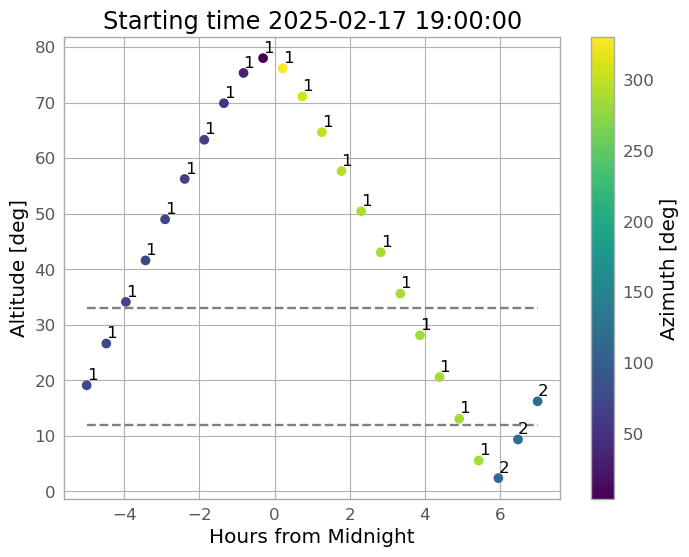

In [34]:
#Other functions

#Take the data from the analysis to graphic
def EstablishCoord(Data):
    ALT = []
    AZ = []
    label = []
    
    for each in Data:
        ALT.append(each['Alt'].iloc[0])
        AZ.append(each['Az'].iloc[0])
        label.append(each['Label'].iloc[0])
    return ALT,AZ,label

ALT,AZ,label = EstablishCoord(Data)

plt.style.use(astropy_mpl_style)
quantity_support()

plt.scatter(time, ALT,c=AZ,cmap="viridis",lw=1)

#Limits of good observations
plt.plot(time, np.linspace(33,33,len(time)),'--',color='grey')
plt.plot(time, np.linspace(12,12,len(time)),'--',color='grey')

plt.colorbar().set_label("Azimuth [deg]")
plt.xlabel("Hours from Midnight")
plt.ylabel("Altitude [deg]")
plt.title('Starting time {}'.format(date_i))

# Loop for annotation of all points 
for i in range(len(time)): 
    plt.annotate(label[i], (time[i], ALT[i] + 1))

plt.show()